In [1]:
# https://www.tensorflow.org/tutorials/images/classification?hl=ko

# 고급 이미지 분류

 이미지에서 고양이 또는 개를 분류 하는 방법을 가지고 실습 !
`tf.keras.Sequential`모델을 사용하여 이미지 분류기를 작성하고를 사용하여 데이터를로드할것이다. 
 
 `tf.keras.preprocessing.image.ImageDataGenerator` 
- 모델과 함께 사용할 디스크의 데이터를 효율적으로 사용하기 위해 클래스를 사용하여 데이터 입력 파이프 라인 구축 tf.keras.preprocessing.image.ImageDataGenerator
- 과적합- 그것을 식별하고 예방하는 방법

- 데이터 확대 및 드롭아웃-컴퓨터 비전 작업에서 과적합하여 데이터 파이프 라인 및 이미지 분류기 모델에 통합하기 위한 주요기술


## 진행 흐름 

1. 데이터 검사 및 이해 
2. 입력 파이프 라인 구출 
3. 모델 구축 
4. 모델 훈련
5. 모델 테스트 
6. 모델 개선 및 프로세스 반복



## 1. 데이터 검사 및 이해

### 패키지 가져오기

os: 파일 및 디렉토리 구조를 판독하는데 사용    
NumPy : 배열 파이썬리스트를 변환하고 요구되는 매트릭스 연산을 수행   
matplotlib.pyplot : 트레이닝 및 검증 데이터의 그래프 표시 이미지를 플롯      

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.1 데이터 로드 

- 데이터 세트를 다운로드 
    - Kaggle 의 필터링 된 버전의 Dogs vs Cats 데이터 세트를 사용한다.
    - 데이터 세트의 아카이브 버전을 다운로드하여 "/ tmp /"디렉토리에 저장한다. 

In [4]:
# https://datascienceschool.net/view-notebook/bc7f54b21a8349c79ecaa4906428dea1/

` tf.keras.utils.get_file() ` :  인터넷의 파일을 로컬 컴퓨터의 홈 디렉토리 아래 .keras/datasets 디렉토리로 다운로드

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# tf.keras.utils.get_file -> ??? 
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

```
cats_and_dogs_filtered 
| __ train 
    | ______ 고양이 : [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    | ______ 개 : [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
| __ validation
    | ______ 고양이 : [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    | ______ 개 : [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
    
```

In [6]:
PATH

'C:\\Users\\admin\\.keras\\datasets\\cats_and_dogs_filtered'

In [7]:
train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')

In [8]:
# train
train_cats_dir = os.path.join(train_dir, 'cats')  # training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # training dog pictures
# validation
validation_cats_dir = os.path.join(validation_dir, 'cats')  # validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # validation dog pictures

## 1.2 데이터의 이해 

- 훈련 및 검증 디렉토리에 고양이와 개 이미지가 몇개인 지 확인해보자 
- 그리고 편의를 위해서 데이터 세트를 사전 처리하고 네트워크를 훈련하는 동안 사용할 변수를 설정하자

In [9]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [10]:
print('총 훈련 고양이 이미지:', num_cats_tr)
print('총 훈련 개 이미지:', num_dogs_tr)

print('총 검증 고양이 이미지:', num_cats_val)
print('총 검증 개 이미지:', num_dogs_val)
print("--")
print("총 학습 이미지:", total_train)
print("총 검증 이미지:", total_val)

총 훈련 고양이 이미지: 1000
총 훈련 개 이미지: 1000
총 검증 고양이 이미지: 500
총 검증 개 이미지: 500
--
총 학습 이미지: 2000
총 검증 이미지: 1000


In [11]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

##  1.3 데이터 준비 

네트워크에 공급하기 전에 이미지를 적절히 사전 처리 된 부동 소수점 텐서로 포멧 

1. 디스크에서 이미지를 읽는다.
2. 이미지 내용을 디코딩해서 RGB 내용에 따라 적절한 격자 형식으로 변환한다. 
3. 부통 소수점 텐서로 변환한다.
4. 신경망은 작은 입력값을 처리하는 것을 선호     
    -> 텐서를 0에서 255 사이의 값에서 0에서 1 사이의 값으로 재조정한다.     
    

모든 작업은 `ImageDataGenerator` 제공하는 클래스로 수행    
tf.keras. 디스크에서 이미지를 읽고 적절한 텐서로 사전 처리 가능하다.     
이러한 이미지를 텐서 배치로 변환하는 생성기를 설정하여 네트워크를 훈련 할 때 유용하다.     

In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255) 

 훈련 및 유효성 검사 이미지 생성기를 정의한다.       
 flow_from_directory을 이용해 디스크에서 이미지를 로드한다.    
 그리고 크기를 조정한 다음 이미지를 필요한 크기로 조정한다.    

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


## Visualize training images(검증용 학습 데이터 )

훈련 생성기(이 예에서는 32 개 이미지)에서 배치 이미지를 추출하여 훈련 이미지를 시각화 한 다음 5 개로 플롯

In [15]:
sample_training_images, _ = next(train_data_gen)

```
next()
next function => 데이터셋에서 배치 사이즈를 돌려준다.
돌아온 값은 (x_train, y_train) 형태를 가지는데 
x_train 는 학습 
y_train은 라벨 

```

In [16]:
sample_training_images.shape

(128, 150, 150, 3)

In [17]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    
    # 데이터를 묶어 뿌린다. 
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

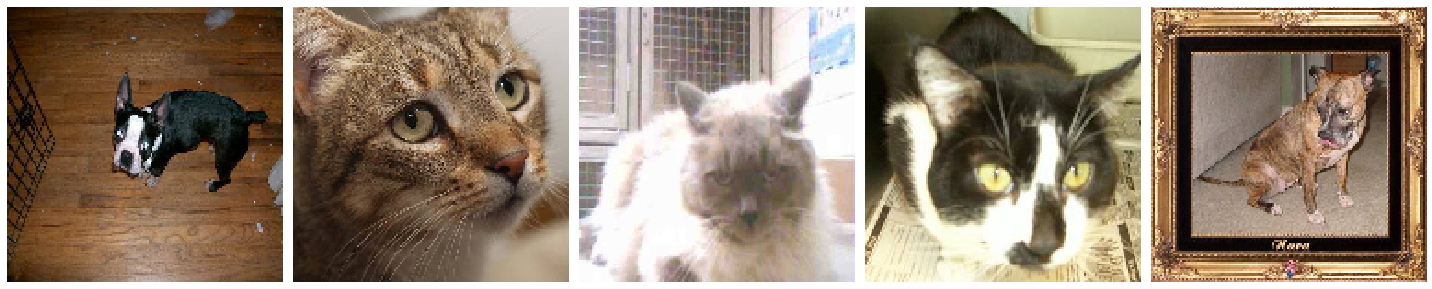

In [18]:
plotImages(sample_training_images[:5])

## 모델 만들기 

이 모델은  맥스풀 레이어가 있는 3개의 블록으로 구성된다.      
풀링레이어는 512개의 유잇으로 연결된다 또한 relu활성화 기능에 의해 완전히 연결된다.       

In [19]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## 모델 컴파일 

ADAM 최적화 프로그램과 이진 교차 엔트로피 손실 기능을 선택해야한다.     
트레인과 벨리데이션의 각 정확도를 보기위해서는 메트릭스에 인수를 전달해야한다.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 모델 요약

모든 네트워크 계층을 확인한다. 

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

## 모델 훈련 

fit_generator방법을 사용하여 ImageDataGenerator네트워크를 훈련

In [22]:
hist = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 25s 2s/step - loss: 0.7767 - acc: 0.4941 - val_loss: 0.6890 - val_acc: 0.4955
Epoch 2/15
15/15 [==============================] - 17s 1s/step - loss: 0.6837 - acc: 0.5144 - val_loss: 0.6850 - val_acc: 0.4955
Epoch 3/15
15/15 [==============================] - 17s 1s/step - loss: 0.6644 - acc: 0.5507 - val_loss: 0.6338 - val_acc: 0.5636
Epoch 4/15
15/15 [==============================] - 18s 1s/step - loss: 0.6153 - acc: 0.6143 - val_loss: 0.5851 - val_acc: 0.7009
Epoch 5/15
15/15 [==============================] - 19s 1s/step - loss: 0.5657 - acc: 0.6795 - val_loss: 0.5539 - val_acc: 0.6741
Epoch 6/15
15/15 [==============================] - 17s 1s/step - loss: 0.5108 - acc: 0.7265 - val_loss: 0.5239 - val_acc: 0.7355
Epoch 7/15
15/15 [==============================] - 17s 1s/step - loss: 0.4730 - acc: 0.7628 - val_loss: 0.5559 - val_acc: 0.6853
Epoch 8/15
15/15 [==============================] - 17s 1s/step - loss: 0.4284 - acc: 0.78

## 훈련 결과 시각화 

네트워크 학습후 결과를 시각화 할것이다. 

In [23]:
# 정확도 
acc = hist.history['acc']  # 학습 정확도
val_acc = hist.history['val_acc'] # 검증 정확도 

# 손실 값
loss=hist.history['loss']
val_loss=hist.history['val_loss']

# 에포크 길이 
epochs_range = range(epochs)

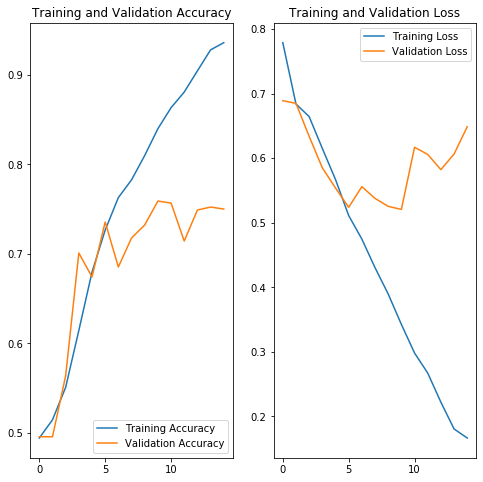

In [24]:
# 그래프 그리기 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


그래프에서 확인 할수 있다 싶이 훈련의 정확도와 유효성 검사 전확도는 큰 마진으로 사라지고 모델은 벨리데이션에서 약70% 를 달성했다. 과적합임을 알 수 있다.

## 과적합 


위의 그림에서 훈련 정확도는 시간이 지남에 따라 선형적으로 증가하는     
반면 검증 데이터의 정확도는 훈련과정에서 약 70%정도에 정지한다.       

두 데이터의 차이가 눈에 띄는 것으로 보면 오버핏이라는 것을 알수있다.

적은 수의 학습 예제가 있는 경우 모델이 새예제에서 모델의 성능에 부정적인 영향을 줄수 있다.    
그렇게 학습 예제의 노이즈 또는 원치 않는 세부 사항으로부터 학습하는 경우를 과적합이라고 한다.    
   
과적합은 새로운 데이터 세트를 일반화 하는데 어려움을 겪을 것임을 의미한다.     
훈련 과정에서 과적합과 해결할수있는 여러가지 방법이 있다.     
여기에서는 데이터 기능 보강하여 사용하고 모델에 드롭아웃을 추가한다.     

## 데이터 확대 
과적합은 일반적으로 적은 수의 훈련 예제가 있을 때 발생한다.    
이문제를 해결하는 한가지 방법은 충분한 수의 학습 예제를 가지는것을 목표로한다.     
데이터를 확장하는 것은 믿을수 있는 이미지를 생성하는 임의의 변환을 사용하여 샘플을 확대    
기존 학습 데이터에서 더 많은 학습데이터를 생성하는 방식이다.   
목표는 모델이 훈련중에 똑같은 그림을 두번 보지 못할것이다.    
모델의 데이터의 더 많은 측면에서 노출시키고 일반화 하는 것에 도움이 될것이다.     

ImageDataGenerator. 다른 변환을 데이터 세트에 전달하면 훈련 과정에서 적용

## 데이터 보강 및 시각화 

데이터 세트의 임의의 수평 플립 확대를 적용하여 시작하고 변환하여 개별 이미지가 어떻게 보이는지 확인 할 것이다. 

## 수평, 뒤집기 등을 적용 

horizontal_flip받는 인자로 ImageDataGenerator클래스와 파라미터를 설정
-> True이 확대 적용


In [25]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [26]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


**학습 예제에서 하나의 샘플 이미지를 가져와서 5회 반복한다.기능 보강이 동일한 이미지에 5번 족용되게 할것이다.**

In [27]:
train_data_gen[0][0][0]

array([[[0.37647063, 0.38431376, 0.43529415],
        [0.37254903, 0.41960788, 0.34117648],
        [0.3529412 , 0.4039216 , 0.3372549 ],
        ...,
        [0.454902  , 0.4666667 , 0.48627454],
        [0.49411768, 0.5058824 , 0.5254902 ],
        [0.4666667 , 0.47450984, 0.5254902 ]],

       [[0.3803922 , 0.4039216 , 0.38823533],
        [0.3921569 , 0.45882356, 0.31764707],
        [0.4039216 , 0.4784314 , 0.36862746],
        ...,
        [0.5568628 , 0.5686275 , 0.5882353 ],
        [0.45882356, 0.47058827, 0.4901961 ],
        [0.5254902 , 0.53333336, 0.58431375]],

       [[0.43529415, 0.48235297, 0.4039216 ],
        [0.23529413, 0.32156864, 0.13725491],
        [0.23137257, 0.33333334, 0.19607845],
        ...,
        [0.5411765 , 0.5529412 , 0.57254905],
        [0.49411768, 0.5058824 , 0.5254902 ],
        [0.48627454, 0.49411768, 0.5411765 ]],

       ...,

       [[0.7372549 , 0.7725491 , 0.7686275 ],
        [0.5803922 , 0.61960787, 0.627451  ],
        [0.854902  , 0

In [28]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

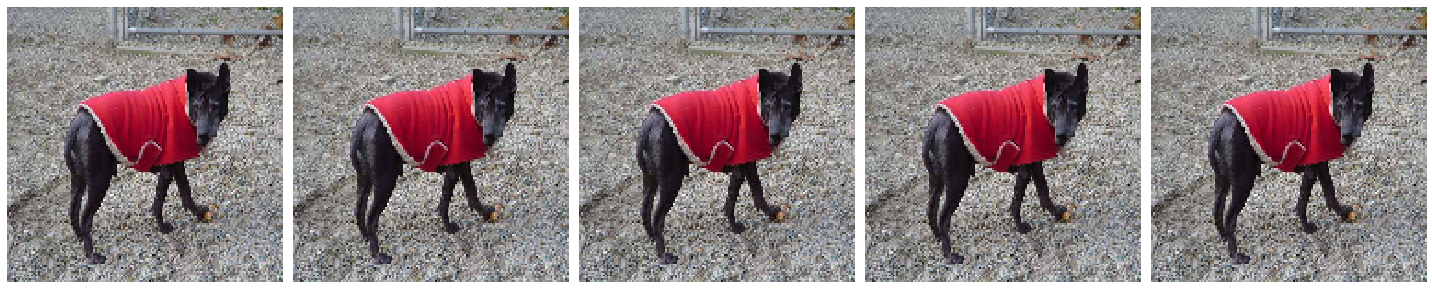

In [29]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

# 이미지를 무작위로 회전 

다른 확대 기능을 살펴보고 훈련데이터에 무작위로 45도 회전을 적용할것이다.

In [30]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [31]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


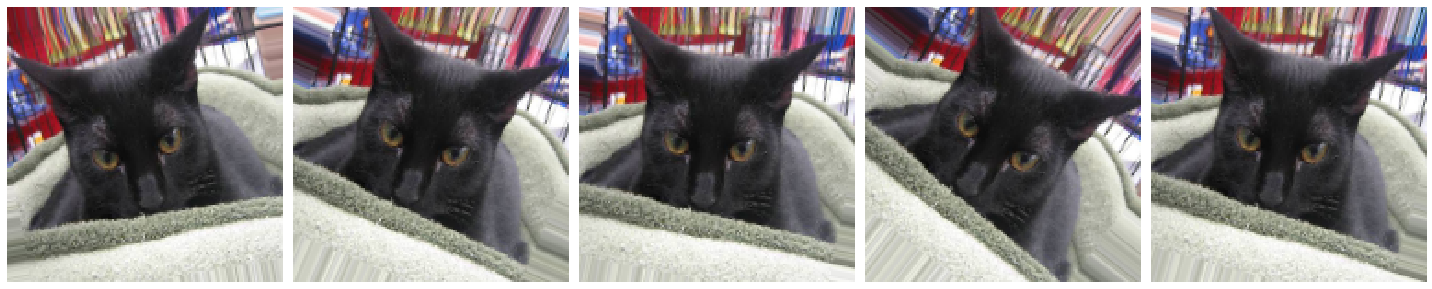

In [32]:
plotImages(augmented_images)

## 확대 적용 

데이터 셋에 확대기능을 적용하여 이미지를 최대 50%까지 무작위로 확대 할것이다.

In [33]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) 

In [34]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


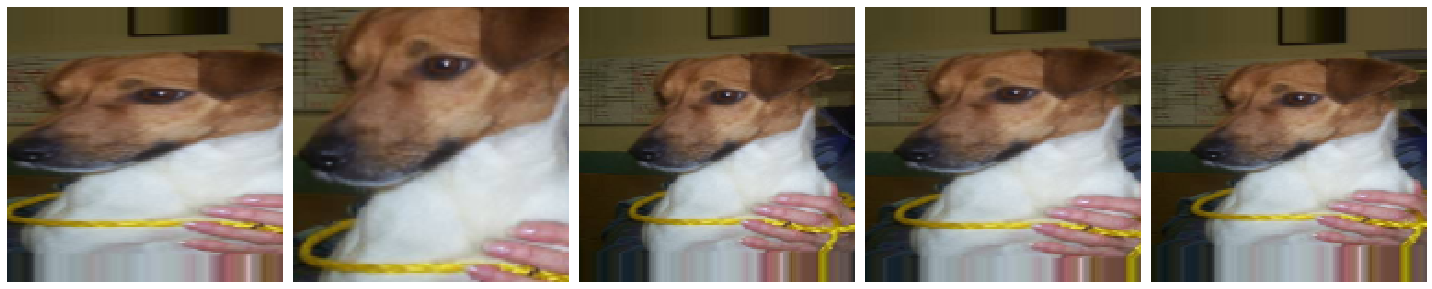

In [35]:
plotImages(augmented_images)

## 위의 데이터 확장을 모두 모아 작업 해보자 

In [36]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [37]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


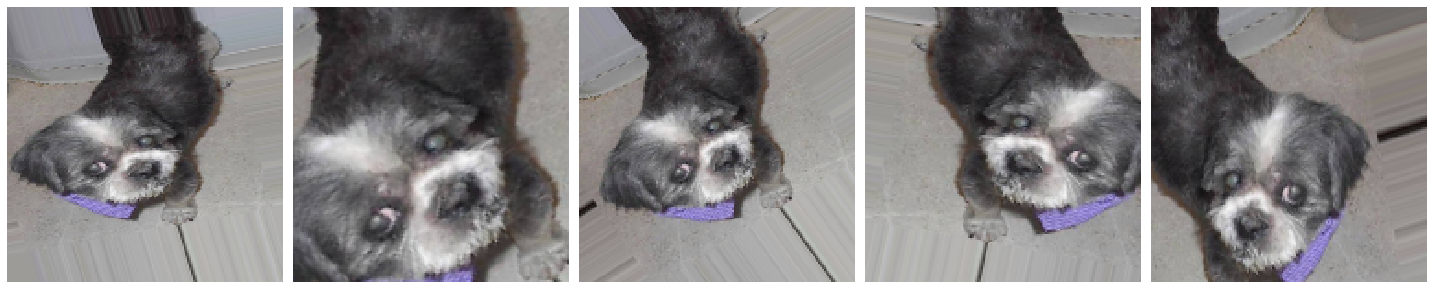

In [38]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## 벨리데이션 데이터 생성기 만들기 

일반적으로 데이터를 보강할때는 훈련예제에만 데이터 기능을 보강해야한다.     
현재의 경우 벨리데이션 이미지의 크기만 조정을하고 사용하여 이미지를 일괄처리로 변환할것이다. 

In [39]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [40]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Dropout 드롭아웃

과적합을 줄이는 다른 방법!! 

네트워크에 드롭아웃을 도입해서 과적합을 줄일 수있다. 
네트워크의 가중치가 작은 값만 취하도록 하는 정규화의 한 형태이다.       
가중치 값의 분포를 보다 규칙적으로 만들고 네트워크는 작은 훈련에서 과적합을 줄일 수 있다.     

드롭아웃은 정규화의 한 형태라고 보면될것같다. 


레이어에 드롭아웃을 적용하면 훈련과정에서 적용된 레이어에서 출력 단위의 수를 임의로 드롭한다. 
(0으로 설정)
드롭아웃은 0.1, 0.2, 0.4 등의 형태로 입력 값으로 소수를 가진다. 
이는 적용된 레이어에서 출력 단위의 10 %, 20 % 또는 40 %를 임의로 제거하는 것을 의미한다. 

특정 레이어에 0.1 드롭 아웃을 적용 할 때 각 트레이닝 에포크에서 출력 단위의 10 %를 임의로 종료된다. 



## 드롭 아웃으로 새로운 네트워크 생성

- 첫 번째 및 마지막 최대 풀 레이어에 드롭 아웃을 적용할것이다.     
- 드롭아웃을 적용하면 각 학습 단위마다 뉴런의 20 %가 임의로 0으로 설정된다. 
- 이것을 통해 훈련데이터가 과적합 되는것을 피할수 있다. 

In [41]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

## 모델 컴파일 

레이어 확인을 해보자 

In [42]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

## 모델 훈련 

기능 보강이후 네트워크에 드롭아웃을 추가하여 학습 

In [43]:
# 새로운 모델을 적용했다. 
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 23s 2s/step - loss: 0.9453 - acc: 0.4920 - val_loss: 0.6934 - val_acc: 0.4967
Epoch 2/15
15/15 [==============================] - 22s 1s/step - loss: 0.6931 - acc: 0.4957 - val_loss: 0.6931 - val_acc: 0.4967
Epoch 3/15
15/15 [==============================] - 22s 1s/step - loss: 0.6930 - acc: 0.5032 - val_loss: 0.6925 - val_acc: 0.4967
Epoch 4/15
15/15 [==============================] - 22s 1s/step - loss: 0.6923 - acc: 0.4957 - val_loss: 0.6873 - val_acc: 0.4967
Epoch 5/15
15/15 [==============================] - 21s 1s/step - loss: 0.6899 - acc: 0.5069 - val_loss: 0.6855 - val_acc: 0.4978
Epoch 6/15
15/15 [==============================] - 22s 1s/step - loss: 0.6874 - acc: 0.5016 - val_loss: 0.6814 - val_acc: 0.5011
Epoch 7/15
15/15 [==============================] - 22s 1s/step - loss: 0.6720 - acc: 0.5464 - val_loss: 0.6644 - val_acc: 0.6038
Epoch 8/15
15/15 [==============================] - 20s 1s/step - loss: 0.6771 - acc: 0.53

## 모델 시각화 

훈련 후 새모델을 시각화 하면 이전보다 과적 합이 현저히 줄어든것을 확인가능하다.

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

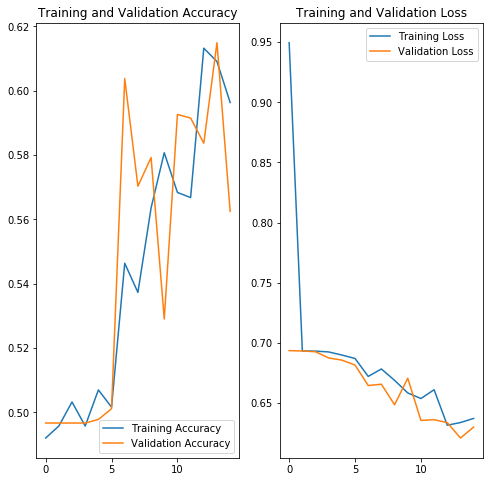

In [45]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()